# Make sweeps in the parameter space of the Mindlin model and create synthetic vocalizations

Uses a RK4 ode integrator to compute segments of synthetic vocaliations of zebra finch (after the Mindlin Model presented in Sanz, Arneodo, Amador, Mindlin 2011 and Arneodo, Sanz, Goller, Mindlin (2012).

Requires package swissknife (https://github.com/zekearneodo/syrinxsynth)

In [2]:
%matplotlib inline
import numpy as np
import logging

from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import scipy.signal as sg

# Import the package that generates synthetic vocalizations
from syrinxsynth.dynamo import finch as zf
from syrinxsynth.dynamo import takens as tk

# Set up a logger
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

2018-11-25 22:34:52,316 matplotlib.backends DEBUG    backend module://ipykernel.pylab.backend_inline version unknown


## Make a grid of parameter values (alpha, beta) in the phonation region
There is a region delimited by a cusp bifurcation and a hopf bifurcation where stable oscilations occur.
Method dynamo.takens.cusp_grid() yields a grid of vaules for the parameters alpha, beta that lies within that region.

6


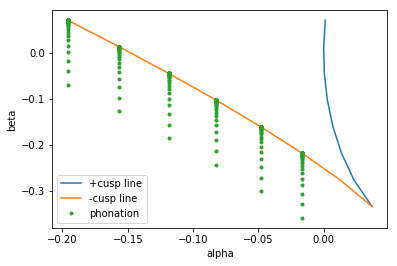

In [102]:
sys_pars = {'alpha_1': 0.15,
            'beta_1': 0.15,
            'alpha_2': 0.15,
            'beta_2': 0.15,
            'gamma': 23500.,
            'Ch_inv': 4.5E10,
            'Lb_inv': 1.E-4,
            'Lg_inv': 1/82.,
            'Rb': 5E6,
            'Rh': 6E5,
            'V_ext': 0.,
            'dV_ext': 0.,
            'noise': 0.,
            'envelope': 0.,
            'noise_fraction_beta_1': 0.1,
            'noise_fraction_env': 0.1,
            's_f': 44100.,
            'steps_per_sample': 20
            }

vocal_pars = {'sys': sys_pars,
              'S_1': 0.2,
              'S_2': 0.2,
              'S_3': 0.2,
              'l_1': 1.5,
              'l_2': 1.5,
              'l_3': 1.0,
              'r_out': 0.1,
              'r_12': None,
              'r_21': None,
              'r_23': None,
              'r_32': None,
              't_12': None,
              't_21': None,
              't_23': None,
              't_32': None,
              't_in': 0.5,
              'tau_1': None,
              'tau_2': None,
              'tau_3': None,
              'max_tau': None,
              'A_1': 0.,
              'A_2': None,
              'A_3': None}

#lines, ab_g= tk.cusp_grid()
lines, ab_grid = tk.cusp_grid(b_max=0.07, b_min=-1/3 , a_step=5E-2, b_steps=50, b_log_step_exp=5, f_max=None);
plt.plot(lines[:,1], lines[:,0], label='+cusp line');
plt.plot(lines[:,2], lines[:,0], label='-cusp line');
plt.plot(ab_grid[:,0], ab_grid[:,1], '.', label='phonation');
plt.xlabel('alpha');
plt.ylabel('beta');
plt.legend();

In the Plot above, every green point is in the region of phonation (i.e, leads to an oscilatory solution).
It is below the SNIC bifurcation line, and left to the Hopf bifurcation line.
Integrating the model for any pair of (alpha, beta) in that group, leads to a synthetic song segment.

#### Now let's pick some of those points and make synthetic sounds

In [109]:
# Pick a sample of those points:
alpha_beta_grid = ab_grid[ab_grid[:,0]<-0.1][::1]
alpha_beta_grid.shape

(150, 2)

In [115]:
from importlib import reload
reload(zf)

<module 'syrinxsynth.dynamo.finch' from '/Users/zeke/repos/syrinxsynth/syrinxsynth/dynamo/finch.py'>

In [119]:
from swissknife.dynamo import finch as zf2

In [120]:
sweep_name = 'sparse_grid'
sim_pars = {'sweep_name' : sweep_name, #just for keeping track of the simulation series
            'gamma': 23500,
            'alpha': 0.,
            'beta': 0.,
            'vocal_pars': vocal_pars, #parameters of the vocal organ
            'sim_samples': 3000, #length of vocalization for each parameter set
            's_f': 30000., #sampling frequency
            'steps_per_sample': 20, # integration step
            'x_0': np.array([5.E-12, 1.E-11, 1.E-12, 1.E-11, 1.E-12])
           }

#allocate memory for the array of simmulated sounds
total_sim = alpha_beta_grid.shape[0]
synth_table = np.zeros([total_sim, sim_pars['sim_samples']])

#run the integration for the grid
for i, (sim_pars['alpha'], sim_pars['beta']) in enumerate(np.nditer([alpha_beta_grid[:,0], alpha_beta_grid[:,1]])):
    if i%10==0:
        logger.info('Simulating {0}/{1} with {0}, {1}'.format(i,
                                                          total_sim, 
                                                          sim_pars['alpha'],
                                                          sim_pars['beta']))
        
    # Make streams of alpha, beta, env parameters for synthesis of song segments
    alpha_values = sim_pars['alpha'] * np.ones(sim_pars['sim_samples'])
    beta_values = sim_pars['beta'] * np.ones(sim_pars['sim_samples'])
    env_values = np.ones(sim_pars['sim_samples'])
    par_stream = np.array([alpha_values, beta_values, env_values]).T
    # Integrate
    song_synth = zf2.finch(vocal_pars, par_stream, x_0=sim_pars['x_0'])
    synth_table[i,:] = song_synth[:,0]

2018-11-26 00:40:21,712 root         INFO     Simulating 0/150 with 0, 150
2018-11-26 00:40:21,712 root         INFO     Simulating 0/150 with 0, 150
2018-11-26 00:40:45,224 root         INFO     Simulating 10/150 with 10, 150
2018-11-26 00:40:45,224 root         INFO     Simulating 10/150 with 10, 150
2018-11-26 00:41:08,500 root         INFO     Simulating 20/150 with 20, 150
2018-11-26 00:41:08,500 root         INFO     Simulating 20/150 with 20, 150


KeyboardInterrupt: 

In [123]:
reload(zf)
%timeit zf.finch(vocal_pars, par_stream, x_0=sim_pars['x_0'])

KeyboardInterrupt: 

In [124]:
reload(zf2)
%timeit zf2.finch(vocal_pars, par_stream, x_0=sim_pars['x_0'])

2.42 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
Now there are synthetic song segments in synth_table, corresponding to the parameter pairs in alpha_beta_grid.

In [121]:
alpha_beta_grid[10]

array([-0.11851324, -0.04525277])

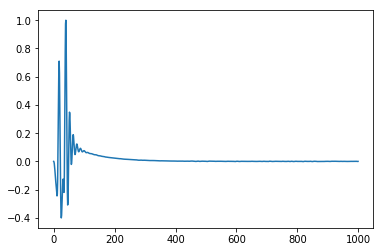

In [122]:
one_synth = synth_table[10]
plt.plot(one_synth[:1000])

In [8]:
# functions using tensorflow
def real_fft(x, only_abs=True, logarithmic=False, window=None):
    """
    Computes fft of a stack of time series.
    :param x: ndarray, shape=(n_series, n_samples)
            Input stack of time series
    :param only_abs: boolean 
            return only absolute values (power spectra)
    :param logarithmic: boolean
            return in logarithmic scale; ignored if only_abs==False
    :param window: ndarray, shape=(n_samples, )
            boxing window (default none), np.array (n_samples)
    :return: ndarray, shape=(n_series, n_samples/2) 
            with fft computed for every row
             dtype=np.float32 (if only_abs==True) or dtype=np.complex64 (if only_abs==False)
    """
    n_series, n_samples = x.shape

    tensor_x = tf.Variable(x, dtype=tf.float32)
    if window is not None:
        assert(window.size == n_samples), 'Window must be size n_samples'
        vector_win = tf.Variable(window.flatten(), dtype=tf.float32)
        tensor_win = tf.reshape(tf.tile(vector_win, [n_series]), [n_series, n_samples])
        real_x = tf.multiply(tensor_x, tensor_win)
    else:
        real_x = tensor_x
    img_x = tf.Variable(np.zeros_like(x), dtype=tf.float32)
    complex_x = tf.complex(real_x, img_x)
    complex_y = tf.fft(complex_x)[:, :int(x.shape[-1]/2)]

    if only_abs:
        amps_y = tf.abs(complex_y)
        if logarithmic:
            log_10 = tf.constant(np.log(10), dtype=tf.float32)
            fft = tf.multiply(tf.log(amps_y), log_10)
        else:
            fft = amps_y
    else:
        fft = complex_y

    model = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(model)
        s = sess.run(fft)
    return s

i=0
rows_chunk = 1000
n_samples = 129 * 2
x_i = p_s.synthetic(i*rows_chunk, rows=rows_chunk)[:, :n_samples]
rft = sp.real_fft(x_i, only_abs=True, logarithmic=True, window=np.ones([1, 129*2]))
rft.shape

(1000, 129)

In [54]:
rft.dtype

dtype('complex64')

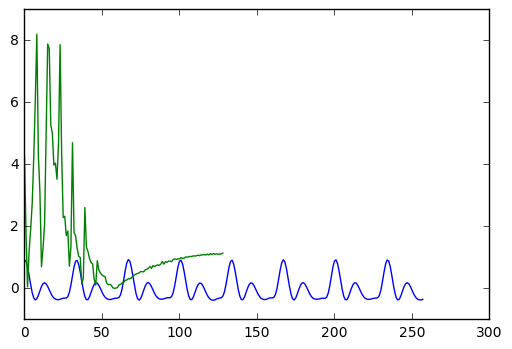

In [74]:
ser=0
plt.plot(x_i[ser])
plt.plot(np.abs(rft[ser]))

In [5]:
from tqdm import tqdm

n_streams = p_s.ab.shape[0]
f_bins = 129
n_samples = f_bins * 2 # resolution of fft is given by n of samples

all_spectra = np.zeros([n_streams, f_bins], dtype=np.float32)
rows_chunk = 1000
for i in tqdm(np.arange(int(n_streams/rows_chunk))):
#for i in tqdm(np.arange(1)):
    x_i = p_s.synthetic(i*rows_chunk, rows=rows_chunk)[:, :n_samples]
    all_spectra[i*rows_chunk:(i+1)*rows_chunk, :] = normalize(regularize(spectral_slice_tf(x_i)))


100%|██████████| 160/160 [01:25<00:00,  1.01s/it]


In [10]:
x_i.shape

(1000, 258)

In [6]:
streams = p_s.synthetic(0, rows=5)[:,:2048]
streams.shape

(5, 2048)

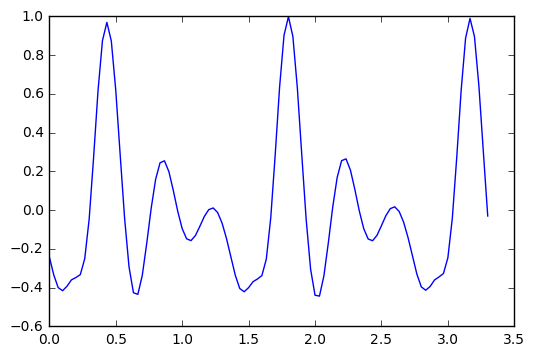

In [7]:
i_stream = 1
t_steps = 100
t = np.arange(x_i.shape[1])/p_s.pars['sys']['s_f']
plt.plot(t[:t_steps]*1000, x_i[i_stream, :t_steps])

In [8]:
syll_data = pd.DataFrame({
        'bird': ['synth' for i in range(all_spectra.shape[0])],
        'sess': [sweep_name for i in range(all_spectra.shape[0])],
        'a': np.array(p_s.ab['a']).tolist(),
        'b': np.array(p_s.ab['b']).tolist(),
        'spectral': normalize(all_spectra).tolist()
    })

syll_data.to_pickle(os.path.join(sweep_folder, 'spectral_pandas_{}.pickle'.format(sweep_name)))

In [13]:
os.path.join(sweep_folder, 'spectral_pandas_{}.pickle'.format(sweep_name))

'/usr/local/experiment/tmp_data/syn_sweeps/spectral_pandas_sweep_001.pickle'

In [9]:
syll_data[:3]

,a,b,bird,sess,spectral
0,-0.08,-0.139136,synth,sweep_002,"[0.29575958848, 0.286303639412, 0.291149049997..."
1,-0.08,-0.139588,synth,sweep_002,"[0.486470043659, 0.435143560171, 0.41754218936..."
2,-0.08,-0.140047,synth,sweep_002,"[0.421198099852, 0.448597162962, 0.45280805230..."


In [13]:
p_s.pars['sys']['s_f']

30000.0

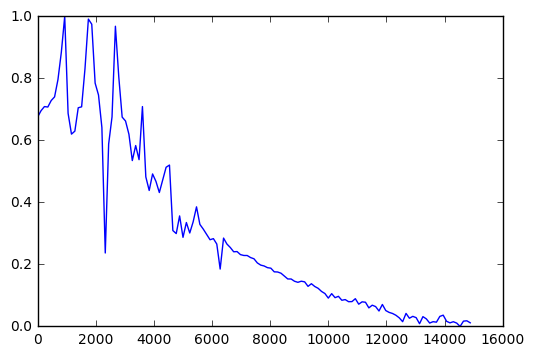

In [9]:
f = np.arange(f_bins)*p_s.pars['sys']['s_f']/f_bins/2
plt.plot(f, all_spectra[i_stream, :])

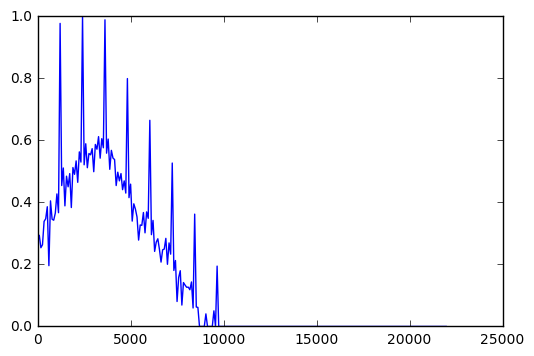

In [15]:
def normalize(u):
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    return (u - u_min)/u_range

plt.plot(f, normalize(all_spectra)[i_stream, :])

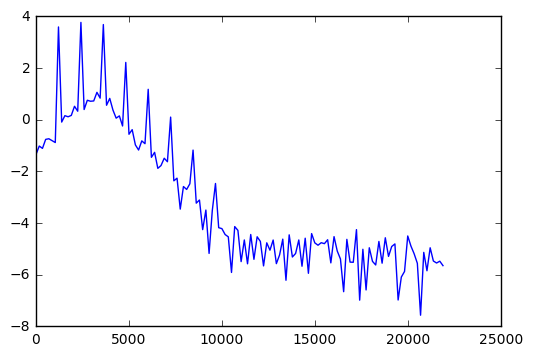

In [165]:
plt.plot(f, np.log(all_spectra[i_stream, :]))

In [166]:
regularize(all_spectra)[i_stream, :]

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in log


TypeError: 'NoneType' object has no attribute '__getitem__'

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in log


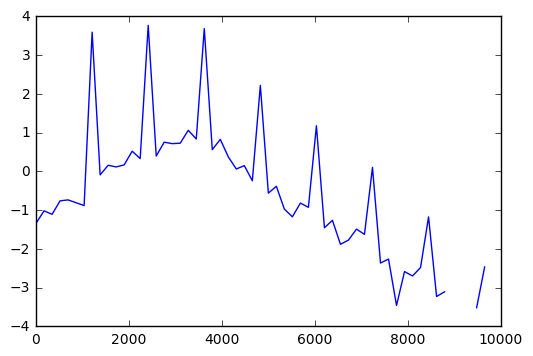

In [148]:
plt.plot(f, regularize(all_spectra)[i_stream, :])

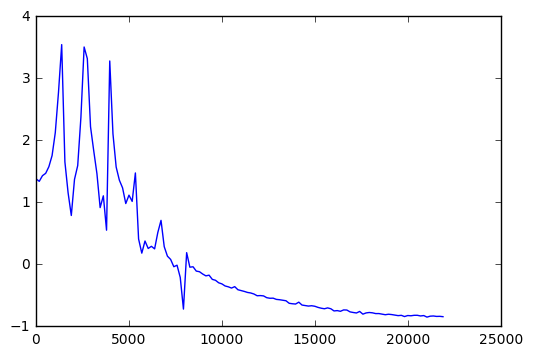

In [119]:
yy = all_spectra[:50]
y_thresh = np.repeat(np.amax(yy, axis = 1, keepdims=True), yy.shape[-1], axis=1)/np.exp(90/10)
yy[yy<y_thresh]=0
plt.plot(f, np.log(yy[20,:]))

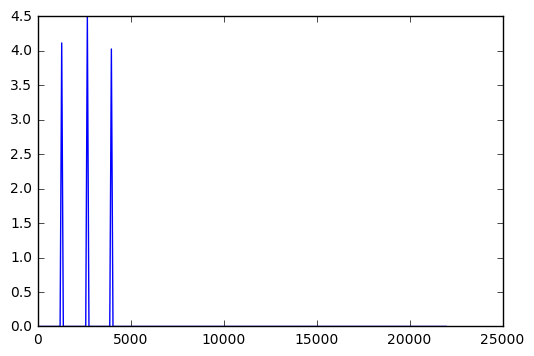

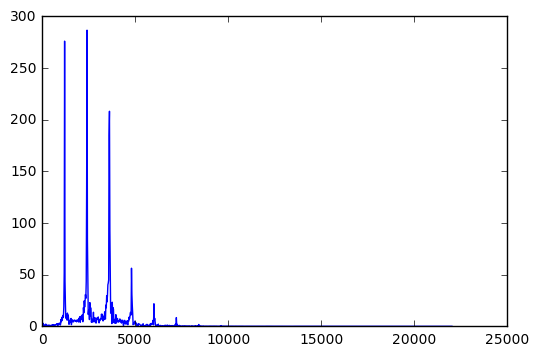

In [35]:
f = np.arange(y.shape[1])*p_s.pars['sys']['s_f']/y.shape[-1]/2
plt.plot(f, y[i_stream,:])

In [8]:
i=1000
print(i)
x = p_s.synthetic(i).flatten()[:2048]
s = spectral_slice_tf(x)
plt.plot(f, s)

1000


NameError: name 'f' is not defined

In [11]:
p_s.ab.shape[0]

160000

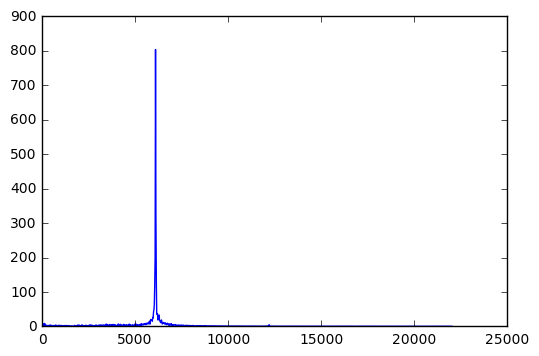

In [33]:
s = spectral_slice_tf(x)
f = np.arange(s.size)*p_s.pars['sys']['s_f']/s.size/2
plt.plot(f, s)

In [28]:
p_s.pars['sys']['s_f']

44100.0

In [31]:
1/.15

6.666666666666667

In [74]:
s

array([ 0.00064711,  0.00051946,  0.00043862, ...,  0.00014497,
        0.00014609,  0.00014595], dtype=float32)

In [7]:
f = h5py.File(sweep_file_path, 'r')
p_s = ParSweep(f, sweep_name)
#one_stream = p_s.synthetic(0, 0)

2016-10-28 00:53:07,897 h5tools      DEBUG    Translating group sweep_pars into its own dictionary
2016-10-28 00:53:07,899 h5tools      DEBUG    Translating group sys into its own dictionary


[(u'sys', <HDF5 group "/sweep_000/vocal_pars/sys" (0 members)>)]
/sweep_000/synth/23500
[(u'alpha_beta', <HDF5 dataset "alpha_beta": shape (159500, 2), type "<f8">), (u'pre_in', <HDF5 dataset "pre_in": shape (159500, 4410), type "<f8">), (u'pre_out', <HDF5 dataset "pre_out": shape (159500, 4410), type "<f8">)]


In [40]:
def slice_compare()

(1, 2205)

In [24]:
import h5tools as h5

In [25]:
h5.tables

<module 'h5tools.tables' from '/mnt/cube/earneodo/repos/swissknife/h5tools/tables.pyc'>

In [34]:
np.arange(5, 10)

array([5, 6, 7, 8, 9])